In [36]:
from scegot import scEGOT
from paths import PROJECT_FOLDER
import scanpy as sc
import numpy as np
import pandas as pd
from scCFM.models.cfm.components.eval.distribution_distances import compute_distribution_distances

from notebooks.utils import decode_trajectory_single_step, standardize, compute_prdc
from tqdm import tqdm
import torch

In [37]:
def update_dict(ref, tgt):
    """
    Update a dictionary with the values of another 
    """
    for key in tgt:
        if key not in ref:
            ref[key] = []
        ref[key].append(tgt[key])
    return ref

Initialize VAEs 

In [38]:
# vae_kwargs={'in_dim': datamodule.in_dim,
#        'n_epochs_anneal_kl': 1000, 
#        'kl_weight': None, 
#        'likelihood': 'nb', 
#        'dropout': False, 
#        'learning_rate': 0.001, 
#        'dropout_p': False, 
#        'model_library_size': True, 
#        'batch_norm': True, 
#        'kl_warmup_fraction': 0.1, 
#        'hidden_dims': [256, 10]}
        
# geometric_kwargs={'compute_metrics_every': 1, 
#            'use_c': True, 
#            'trainable_c': False,
#            'l2': True, 
#            'eta_interp': 0, 
#            'interpolate_z': False, 
#            'start_jac_after': 0, 
#            'fl_weight': 0.1,
#            'detach_theta': True}

# geodesic_kwargs={"in_dim": datamodule.in_dim,
#           "hidden_dims": [256, 10],
#           "batch_norm": True,
#           "dropout": False, 
#           "dropout_p": False,
#           "likelihood": "nb",
#           "learning_rate": 0.001}

# # Initialize vae and geometric vae
# vae = GeometricNBVAE(**geometric_kwargs, vae_kwargs=vae_kwargs).to(device)
# geometric_vae = GeometricNBVAE(**geometric_kwargs, vae_kwargs=vae_kwargs).to(device)
# geodesic_ae = GeodesicAE(**geodesic_kwargs).to(device)

# # Load state dicts and put in eval mode 
# vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al_complete/best_model_vae_lib.ckpt")["state_dict"])
# geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al_complete/best_model_geometric_lib.ckpt")["state_dict"])
# geodesic_ae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al_complete/best_model_geodesic_ae.ckpt")["state_dict"])

Read dataset 

In [39]:
adata_schiebinger = sc.read_h5ad( '/home/icb/alessandro.palma/environment/scCFM/project_dir/data/schiebinger_et_al/processed/schiebinger_et_al.h5ad')

In [40]:
idx2time = {}
leaveout = []
for id, time in enumerate(np.unique(adata_schiebinger.obs.experimental_time)):
    idx2time[id] = time

## For loop interpolations 

Fixed parameters 

In [41]:
RANDOM_STATE = 42
PCA_N_COMPONENTS = 50
GMM_CLUSTER_NUMBERS = list(range(1,41))
UMAP_N_NEIGHBORS = 30

Initialize model 

In [42]:
scegot = scEGOT(
    adata_schiebinger,
    verbose=True,  # default=True
    adata_day_key="experimental_time",
)

Processing AnnData...


Preprocessing

In [43]:
X, pca_model = scegot.preprocess(50,
                                 recode_params={},
                                 umi_target_sum=1e5,
                                 pca_random_state=42,
                                 pca_other_params={},
                                 apply_recode=False,
                                 apply_normalization_log1p=False,
                                 apply_normalization_umi=False,
                                 select_genes=False,
                                 n_select_genes=2000,
                                 )

Applying PCA...
	sum of explained_variance_ratio = 56.06892409406458


In [ ]:
gmm_models, gmm_labels = scegot.fit_predict_gmm(
    n_components_list=GMM_CLUSTER_NUMBERS,
    covariance_type="full",
    max_iter=2000,
    n_init=10,
    random_state=42,
    gmm_other_params={},
    use_pca=False
)

Fitting GMM models with each day's data and predicting labels for them...


 77%|███████▋  | 30/39 [2:34:49<39:25, 262.88s/it]  

In [59]:
# LATENT SPACE METRICS
leaveout_ckpt_latent = {}

# DATA SPACE METRICS
leaveout_ckpt_data= {}

for lt in tqdm([2, 5, 1, 15, 20, 25, 30]):
    # Take time data frame
    adata_time = adata_schiebinger[adata_schiebinger.obs["experimental_time"]==idx2time[lt]]
    X_interpolation = scegot.make_interpolation_data(gmm_models[lt-1],
                                                        gmm_models[lt+1],
                                                        t=0.5,
                                                        columns=None, 
                                                        n_samples=adata_time.shape[0])
    X_interpolation = np.array(X_interpolation)

    # AnnData of interpolations 
    adata_interpolation = sc.AnnData(X=X_interpolation)
    # Save into normalized layer
    adata_interpolation.layers["X_norm"] = np.exp(X_interpolation)-1
    # Compute PCA
    sc.tl.pca(adata_interpolation) 
    
    
    d_dist_vae_d = compute_prdc(adata_interpolation.obsm["X_pca"], 
                                adata_time.obsm["X_pca"], 
                                nearest_k=10)

    t_adata_time = torch.tensor(adata_time.layers["X_norm"].A[:,None,:])
    t_X_interpolation = torch.tensor(adata_interpolation.layers["X_norm"][:,None,:])

    d_distrib =  compute_distribution_distances(t_adata_time.float(), 
                                                t_X_interpolation.float())
    
    d_distrib = dict(zip(d_distrib[0], d_distrib[1]))

    leaveout_ckpt_data = update_dict(leaveout_ckpt_data, d_dist_vae_d)
    leaveout_ckpt_data = update_dict(leaveout_ckpt_data, d_distrib)

100%|██████████| 7/7 [2:33:47<00:00, 1318.23s/it]


In [63]:
pd.DataFrame(leaveout_ckpt_data).mean(0)

precision        1.822582e-01
recall           1.027406e-01
density          4.602788e-02
coverage         6.115885e-02
1-Wasserstein    8.127940e+01
2-Wasserstein    1.181822e+02
Linear_MMD       3.975769e+03
Poly_MMD         2.797424e+08
RBF_MMD          4.428361e-02
Mean_MSE         6.936851e-01
Mean_L2          7.197461e-01
Mean_L1          1.537784e-01
Median_MSE       3.849620e-01
Median_L2        5.339734e-01
Median_L1        1.359749e-01
dtype: float64

In [61]:
leaveout_ckpt_data

{'precision': [0.08442982456140351,
  0.42114642114642115,
  0.22644244708611191,
  0.19482315747875914,
  0.20355466130114017,
  0.13955637707948243,
  0.005854177754124534],
 'recall': [0.14830043859649122,
  0.03578853578853579,
  0.10234850681356915,
  0.16893894487255484,
  0.04594232059020791,
  0.09519408502772643,
  0.12267163384779138],
 'density': [0.012033991228070176,
  0.1321948321948322,
  0.04798492316613512,
  0.047283145623394585,
  0.03628437290409122,
  0.045748613678373386,
  0.0006652474720596061],
 'coverage': [0.01864035087719298,
  0.10974160974160974,
  0.023485068135691504,
  0.12369097016399921,
  0.04393024815560027,
  0.10489833641404805,
  0.0037253858435337944],
 '1-Wasserstein': [63.50626475089468,
  44.705875297310605,
  106.71306539653281,
  36.82599865488096,
  71.87312867032207,
  125.87127494459484,
  119.46022558998995],
 '2-Wasserstein': [66.46084889418226,
  48.05530947294164,
  119.87515465096222,
  40.156868712537836,
  89.45185191260526,
  323

In [62]:
d_distrib

{'1-Wasserstein': 119.46022558998995,
 '2-Wasserstein': 140.2681987163453,
 'Linear_MMD': 9405.51171875,
 'Poly_MMD': 213552448.0,
 'RBF_MMD': 0.025163114070892334,
 'Mean_MSE': 0.6164079308509827,
 'Mean_L2': 0.7851165078196883,
 'Mean_L1': 0.20739218592643738,
 'Median_MSE': 0.13824842870235443,
 'Median_L2': 0.3718177358630898,
 'Median_L1': 0.11184754967689514}

Plots

In [46]:
real_generated_adata = sc.AnnData(X=np.concatenate([X_interpolation, adata_time.X.A]))
label = ["Interp" for _ in range(len(X_interpolation))] + ["Real" for _ in range(len(adata_time))]
label = pd.DataFrame(label)
label.columns = ["dataset_type"] 
real_generated_adata.obs = label

In [47]:
sc.tl.pca(real_generated_adata)
sc.pp.neighbors(real_generated_adata)
sc.tl.umap(real_generated_adata)

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



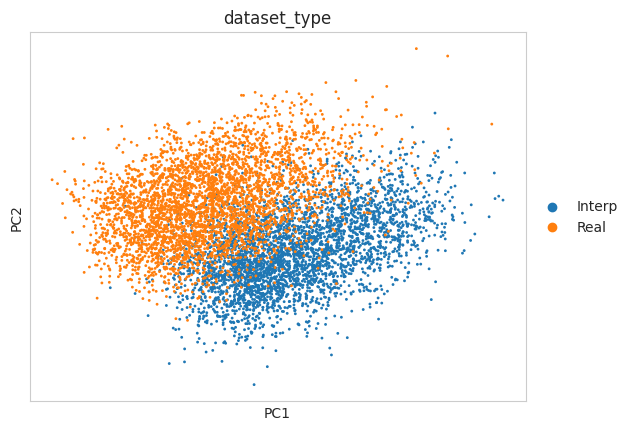

In [48]:
sc.pl.pca(real_generated_adata, color="dataset_type")

In [49]:
t_adata_time.max()

tensor(319.5041)